# Testing regularization of likelihood functions

In [1]:
%pylab inline
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"]="0"
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.append('../../utils/flowpm/')

In [3]:
from matplotlib.colors import LogNorm

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_hub as hub


In [20]:
import numpy as np
import numpy, os
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
from  astropy.cosmology import Planck15
from background import MatterDominated, RadiationDominated


def cic_readout(mesh, part, cube_size=None, boxsize=None):
    """                                                                                                                                                                         
        - mesh is a cube                                                                                                                                                        
        - part is a list of particles (:, 3), positions assumed to be in                                                                                                        
    mesh units if boxsize is None                                                                                                                                               
        - cube_size is the size of the cube in mesh units                                                                                                                       
    """

    if cube_size is None: cube_size = int(mesh.shape[0].value)
    if boxsize is not None:
        part = tf.multiply(part, cube_size/boxsize)

    # Extract the indices of all the mesh points affected by each particles                                                                                                     
    part = tf.expand_dims(part, 1)
    floor = tf.floor(part)
    connection = tf.constant([[[0,], [1.]]])
    neighboor_coords = tf.add(floor, connection)

    kernel = 1. - tf.abs(part - neighboor_coords)
    kernel = tf.reduce_prod(kernel, axis=-1, keepdims=False)

#     if cube_size is not None:                                                                                                                                                 
    neighboor_coords = tf.cast(neighboor_coords, tf.int32)
    neighboor_coords = tf.mod(neighboor_coords , cube_size)

    meshvals = tf.gather_nd(mesh, neighboor_coords)
    weightedvals = tf.multiply(meshvals, kernel)
    value = tf.reduce_sum(weightedvals, axis=1)
    return value



def laplace(config):
    kvec = config['kvec']
    kk = 0
    for k in config['kvec']:
        kk = kk + k**2
#     kk = np.sum(ki**2 for ki in kvec)
    mask = (kk == 0).nonzero()
    kk[mask] = 1
    wts = 1/kk
    imask = (~(kk==0)).astype(int)
    wts *= imask
    return wts



def gradient(config, dir):
    kvec = config['kvec']
    bs, nc = config['boxsize'], config['nc']
    cellsize = bs/nc
    w = kvec[dir] * cellsize
    a = 1 / (6.0 * cellsize) * (8 * numpy.sin(w) - numpy.sin(2 * w))
    wts = a*1j
    return wts


def r2c(rfield, norm=None, dtype=tf.complex64, name=None):
    if norm is None: norm = tf.cast(tf.reduce_prod(tf.shape(rfield)), dtype)
    else: norm = tf.cast(norm, dtype)
    cfield = tf.multiply(tf.spectral.fft(tf.cast(rfield, dtype)), 1/norm, name=name)
    return cfield


def c2r(cfield, norm=None, dtype=tf.float32, name=None):
    if norm is None: norm = tf.cast(tf.reduce_prod(tf.shape(rfield)), dtype)
    else: norm = tf.cast(norm, dtype)
    rfield = tf.multiply(tf.cast(tf.spectral.ifft(cfield), dtype), norm, name=name)
    return rfield


def fftk(shape, boxsize, symmetric=True, finite=False, dtype=np.float64):
    """ return k_vector given a shape (nc, nc, nc) and boxsize                                                                                                                  
    """
    k = []
    for d in range(len(shape)):
        kd = numpy.fft.fftfreq(shape[d])
        kd *= 2 * numpy.pi / boxsize * shape[d]
        kdshape = numpy.ones(len(shape), dtype='int')
        if symmetric and d == len(shape) -1:
            kd = kd[:shape[d]//2 + 1]
        kdshape[d] = len(kd)
        kd = kd.reshape(kdshape)

        k.append(kd.astype(dtype))
    del kd, kdshape
    return k


def genwhitenoise(nc, seed, type='complex'):
    white = tf.random_normal(shape=(nc,), mean=0, stddev=nc**0.5, seed=seed)
    if type == 'real': return white
    elif type == 'complex':
        whitec = r2c(white, norm=nc)
        return whitec


def linfield(config, seed=100, name='linfield'):
    '''generate a linear field with a given linear power spectrum'''

    bs, nc = config['boxsize'], config['nc']
    kmesh = 0
    for k in config['kvec']:
        kmesh = kmesh + k**2
    kmesh = kmesh**0.5
#     kmesh = np.sum(kk**2 for kk in config['kvec'])**0.5
    pkmesh = config['ipklin'](kmesh)

    whitec = genwhitenoise(nc, seed, type='complex')
    lineark = tf.multiply(whitec, (pkmesh/bs)**0.5)
    linear = c2r(lineark, norm=nc, name=name)
    return linear


def lpt1(dlin_k, pos, config):
    """ Run first order LPT on linear density field, returns displacements of particles                                                                                         
        reading out at q. The result has the same dtype as q.                                                                                                                   
    """
    bs, nc = config['boxsize'], config['nc']
    #ones = tf.ones_like(dlin_k)                                                                                                                                                
    lap = laplace(config)

    displacement = tf.zeros_like(pos)
    displacement = []
    for d in range(config['ndim']):
        kweight = gradient(config, d) * lap
        dispc = tf.multiply(kweight, dlin_k)
        disp = c2r(dispc, norm=nc)
        displacement.append(cic_readout(disp, pos, boxsize=bs))

    return tf.stack(displacement, axis=1)




def lptz0(lineark, config, a=1, order=2):
    '''one step 2 LPT displacement to z=0'''
    bs, nc = config['boxsize'], config['nc']
    pos = config['grid']

    DX1 = 1 * lpt1(lineark, pos, config)

    if order == 2: 
#         DX2 = 1 * tflpt1(tflpt2source(lineark, config), pos, config)
        return None
    else: DX2 = 0
    return tf.add(DX1 , DX2)


class Config1d(dict):
    def __init__(self, bs=100., nc=16, seed=100, B=1, stages=None, cosmo=None,
                 pkfile=None, pkinitfile=None, dtype=np.float32):

        self['dtype'] = dtype
        self['boxsize'] = dtype(bs)
        self['shift'] = 0.0
        self['nc'] = int(nc)
        self['kny'] = np.pi*nc/bs
        self['ndim'] = 1
        self['seed'] = seed
        self['pm_nc_factor'] = B
        self['resampler'] = 'cic'
        #                                                                                                                                                                       
        self['cosmology'] = Planck15
        if stages is None: stages = numpy.linspace(0.1, 1.0, 5, endpoint=True)
        self['stages'] = stages
        self['aout'] = [1.0]
        self['perturbation'] = MatterDominated(cosmo=self['cosmology'], a=self['stages'])
        #self['perturbation'] = RadiationDominated(cosmo=self['cosmology'], a=self['stages'])                                                                                   
        #                                                                                                                                                                       
        self['kvec'] = fftk(shape=(nc, ), boxsize=bs, symmetric=False, dtype=dtype)
        self['grid'] = bs/nc*np.indices((nc, )).reshape(1, -1).T.astype(dtype)
        self['pkfile'] = '../../utils/flowpm/Planck15_a1p00.txt'
        self['klin'] = np.loadtxt(self['pkfile']).T[0]
        self['plin'] = np.loadtxt(self['pkfile']).T[1]
        self['ipklin'] = iuspline(self['klin'], self['plin'])
        #                                                        

In [21]:
from time import time

In [22]:
start = time()
tf.reset_default_graph()
inits, fins = [], []

nc = 32
config = Config1d(nc=nc)
for ii in range(100):
    lf_t = linfield(config, seed=ii)
    za_t = lptz0(r2c(lf_t), config, order=1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        lf = sess.run(lf_t)
        za = sess.run(za_t)
    inits.append(lf.copy())
    fins.append(za.copy())


print(time() - start)

13.374894380569458


In [23]:
inits = np.array(inits)
fins = np.squeeze(np.array(fins))


In [24]:
inits.shape, fins.shape

((100, 32), (100, 32))

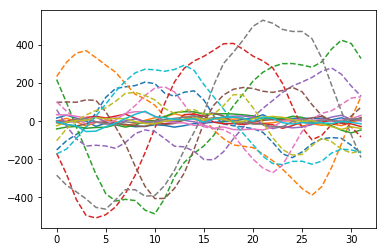

In [25]:
for ii in range(10):
    plt.plot(inits[ii], 'C%d'%ii)
    plt.plot(fins[ii], 'C%d--'%ii)


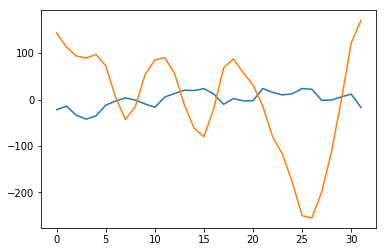

In [26]:
plt.plot(lf)
plt.plot(za)

In [ ]:
%%bash
ls ./modules/
rm -r ./modules/fwdmodel/


In [ ]:
module.export('./modules/fwdmodel', sess)


# Module

Train a neural network in a module 

In [16]:
tf.reset_default_graph()

nsize = 256

def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, nc], name='input')
    y = tf.placeholder(tf.float32, shape=[None, nc], name='output')

    reg = tf.contrib.layers.l2_regularizer(0.001)

    net = tf.layers.dense(x,nsize, activation=tf.nn.leaky_relu, kernel_regularizer=reg)
    net = net + tf.layers.dense(net,nsize, activation=tf.nn.leaky_relu, kernel_regularizer=reg)
    net = net + tf.layers.dense(net,nsize, activation=tf.nn.leaky_relu, kernel_regularizer=reg)
    net = tf.layers.dense(net,nc, activation=tf.nn.leaky_relu, name='rate')
    loglik = tf.reduce_sum(tf.square(tf.add(net, -y)), axis=-1)
    #
    # 
    inputs = dict(input=x, label=y)
    outputs = dict(default=net, loglik=loglik, prediction=sample)
    hub.add_signature(inputs={'features':x, 'labels':y}, 
                          outputs={'sample':net, 'loglikelihood':loglik, 'rate':net})
    
#####                                                                                                                                                                                                                                                                                     


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[None, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc], name='input')
rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
loss = loglik#tf.reduce_sum(tf.square(tf.add(rate, -yy)), axis=-1)
loss = tf.reduce_mean(loss)

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]

data_size = 100
batch_size = 32

for i in range(5000):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = fins[inds]/fins.std()
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
    losses.append(l)
    if i%1000 ==0: print(l)
for i in range(5000):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = fins[inds]/fins.std()
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0001})
    losses.append(l)
    if i%1000 ==0: print(l)
        
# for i in range(5000):
#     inds = np.random.randint(0, data_size, batch_size)
#     l,_= sess.run([loss, train_op], feed_dict={xx:sx[inds], yy:sy[inds], lr:0.0005})
#     losses.append(l)
#     if i%1000 ==0: print(l)
# pred = sess.run(sample, feed_dict={xx:sx})
learn = sess.run(rate, feed_dict={xx:inits, yy:y})


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
5670.9907
4.8371544
2.0485911
2.7060742
1.2597226
0.9310181
0.002664866
0.00037794776
3.676335e-05
1.5177184e-05


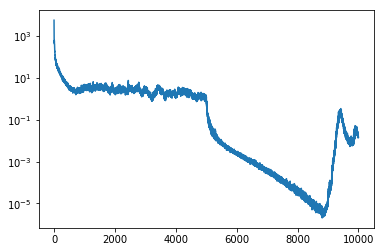

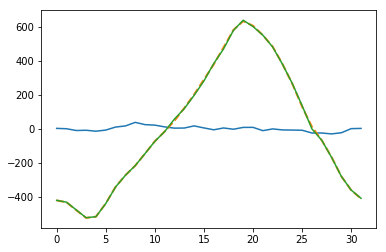

In [17]:
plot(losses)
plt.yscale('log')
plt.show()
ii = 65
plt.plot(inits[ii])
plt.plot(fins[ii], '--', lw=2)
plt.plot(learn[ii]*fins.std())

In [18]:
%%bash
ls modules/
rm -r ./modules/densemoduleza


densemodule
densemoduleza
fwdmodel
specdensemodule
specdensemoduleza


In [19]:
module.export('./modules/densemoduleza', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/densemoduleza


# Reconstruct here

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


In [139]:
mesh = sum(kk**2 for kk in config['kvec'])**0.5
priorwt = config['ipklin'](kmesh) * config['boxsize'] ** -3

def dorecon(yy, xinit, modname, useprior=True, niter=5000, lr=0.001):
    tf.reset_default_graph()
    module = hub.Module(modname, trainable=False)

    xrecon = tf.get_variable('xrecon',
                             initializer=xinit, 
                             trainable=True)

    loglik = module({'features':xrecon, 'labels':yy}, as_dict=True)['loglikelihood']

    xreconk = r2c(xrecon)
    priormesh = tf.square(tf.cast(tf.abs(xreconk), tf.float32))
    prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt), axis=-1)
    prior = tf.multiply(prior, 1/nc, name='prior')

#     prior = tf.square(xrecon)    
# #     prior = tf.multiply(prior, stddevs**-2)
#     prior = tf.multiply(prior, 1**-2)
#     prior = tf.reduce_sum(prior, axis=-1)
    if useprior: loss = tf.add(loglik, prior)
    else: loss = loglik
#   
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    opt_op = optimizer.minimize(loss, var_list=[xrecon])


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        xinit = sess.run(xrecon)
        losses = []
        priors = []
        for it in range(niter+1):
            _, l, p = sess.run([opt_op, loss, prior])
            if it%1000==0: print(l[0])
            losses.append(l)
            priors.append(p)
        xfin = sess.run(xrecon)
        
    return xfin, losses, priors

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


In [187]:
tf.reset_default_graph()
modname = './modules/densemoduleza//'
xfins = []
losses = []
priors = []
xinit = []

nstart = 100
for i in range(1):
    ii = 2*i
    seed(100)
    yy = np.array([fins[ii].copy() for j in range(nstart)])
    yy = yy/fins.std()
    xi = 2*randn(nstart,nc)
    xi = xi.astype('float32')
    recons = dorecon(yy, xi, modname, useprior=False, niter=10000, lr=0.1)
    xfin = np.squeeze(recons[0])
    xfins.append(xfin)
    losses.append(np.squeeze(recons[1]))
    priors.append(np.squeeze(recons[2]))
    xinit.append(xi)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore
9.410315
0.77967954
0.6553782
0.60124016
0.54540104
0.47157186
0.43577418
0.4132236
0.39839265
0.38555926
0.37480375


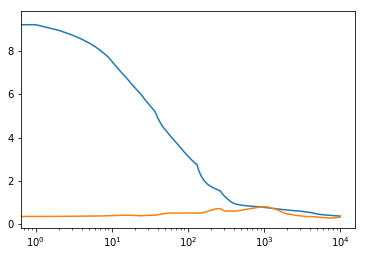

In [188]:
ii = 0
plt.plot(losses[0][:, ii])
plt.plot(priors[0][:, ii])
# plt.yscale('log')
plt.xscale('log')


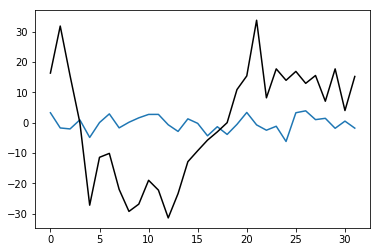

In [190]:
# plt.plot(xfins[0].T)
plt.plot(xfins[0].T.mean(axis=-1))
plt.plot(inits[0], 'k')
plt.show()

In [197]:
tf.reset_default_graph()
module = hub.Module(modname, trainable=False)

xx = tf.placeholder(tf.float32, shape=[None, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc], name='input')
rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']

sess = tf.Session()
sess.run(tf.global_variables_initializer())
reconfins = sess.run(rate, feed_dict={xx:xfins[0], yy:y})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


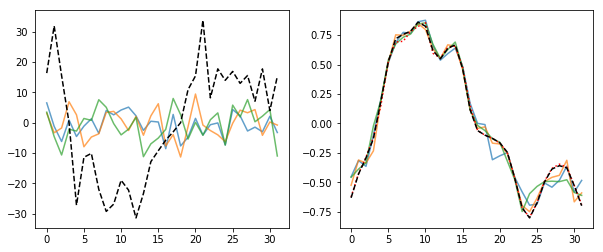

In [214]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

axis= ax[0]
for ii in (1, 5, 10):
    axis.plot(xfins[0][ii], alpha=0.7)
axis.plot(inits[0], 'k--')

axis= ax[1]
for ii in (1, 5, 10):
    axis.plot(reconfins[ii], alpha=0.7)
plt.plot(learn[0], 'r:')
plt.plot(fins[0]/fins.std(), 'k--')

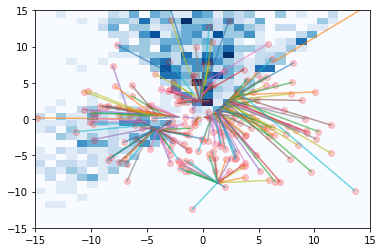

In [106]:
# # With prior
# i=2
# ii = 2*i
# m = (sy == ii)
# hist2d(sx[:,0][m], sx[:,1][m],
#                     32,range=[[-15,15],[-15,15]],normed=True, cmap='Blues') ;
# plot([xinit[i][:200,0],xfins[i][:200,0]], [xinit[i][:200,1],xfins[i][:200,1]],alpha=0.6);
# scatter(xinit[i][:200,0], xinit[i][:200,1],alpha=0.2, color='r');

In [104]:
# fig, ax = plt.subplots(2,4, figsize=(14, 8), sharex=True, sharey=True)
# for i in range(4):
#     ii = 2*i
#     m = (sy == ii)
#     print(ii, m.sum())
#     ax[0, i].hist2d(sx[:,0][m], sx[:,1][m],
#                     32,range=[[-4,4],[-4,4]],normed=True)
#     ax[1, i].hist2d(xfins[i].T[0].flatten(), xfins[i].T[1].flatten(),
#                     32, range=[[-4,4],[-4,4]],normed=True)
#     ax[0, i].set_title('i = %d'%ii)
#     ax[0, 0].set_ylabel('Truth')
#     ax[1, 0].set_ylabel('Recon')
    
# for axis in ax.flatten(): axis.grid(which='both')
#     # plt.colorbar()


# Custom dense layer

In [107]:
import sys
sys.path.append('../../utils/')
import tfops, layers
from layers import SpecDenseLayer


tf.reset_default_graph()

nsize = 256

def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, nc], name='input')
    y = tf.placeholder(tf.float32, shape=[None, nc], name='output')


    net = SpecDenseLayer(nsize, activation=tf.nn.leaky_relu)(x)
    net = net + SpecDenseLayer(nsize, activation=tf.nn.leaky_relu)(net)
    net = net + SpecDenseLayer(nsize, activation=tf.nn.leaky_relu)(net)
    net = SpecDenseLayer(nc, activation=tf.nn.leaky_relu)(net)
    loglik = tf.reduce_sum(tf.square(tf.add(net, -y)), axis=-1)
    sample = net
    #
    # 
    inputs = dict(input=x, label=y)
    outputs = dict(default=net, loglik=loglik, prediction=sample)
    hub.add_signature(inputs={'features':x, 'labels':y}, 
                          outputs={'sample':sample, 'loglikelihood':loglik, 'rate':net})
    
#####                                                                                                                                                                                                                                                                                     


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[None, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc], name='input')
rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
loss = loglik
loss = tf.reduce_mean(loss)

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]

data_size = 100
batch_size = 32

for i in range(5000):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = fins[inds]/fins.std()
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
    losses.append(l)
    if i%1000 ==0: print(l)
for i in range(5000):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = fins[inds]/fins.std()
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0001})
    losses.append(l)
    if i%1000 ==0: print(l)
        
# for i in range(5000):
#     inds = np.random.randint(0, data_size, batch_size)
#     l,_= sess.run([loss, train_op], feed_dict={xx:sx[inds], yy:sy[inds], lr:0.0005})
#     losses.append(l)
#     if i%1000 ==0: print(l)
# pred = sess.run(sample, feed_dict={xx:sx})
learnspec = sess.run(rate, feed_dict={xx:inits, yy:y})


../../utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
../../utils/tfops.py:35: UserWarning: Setting update_collection 

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
1036.2695
1.7122905
1.2577829
0.67492574
0.72556937
0.16807508
0.0074512637
0.002820199
0.00088869
0.00018204737


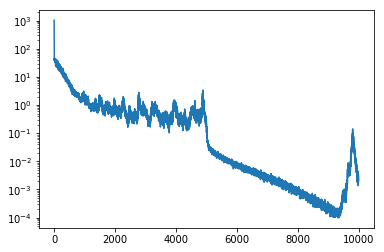

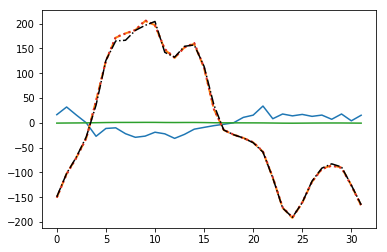

In [108]:
plot(losses)
plt.yscale('log')
plt.show()
ii = 0
plt.plot(inits[ii])
plt.plot(fins[ii], '--', lw=2)
plt.plot(learnspec[ii])
plt.plot(learnspec[ii]*fins.std(), ':', lw=2)
plt.plot(learn[ii]*fins.std(), 'k-.')

In [109]:
%%bash
ls ./modules/
rm -r ./modules/specdensemoduleza


densemodule
densemoduleza
fwdmodel
specdensemodule
specdensemoduleza


In [110]:
module.export('./modules/specdensemoduleza', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/specdensemoduleza


In [117]:
tf.reset_default_graph()
modname = './modules/densemodule/'
module = hub.Module(modname, trainable=False)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    kern = sess.run(tf.get_collection('variables')[2])

tf.reset_default_graph()
modname = './modules/specdensemodule/'
module = hub.Module(modname, trainable=False)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    var = tf.get_collection('variables')[3]
    print(var)
    kernspec = sess.run(var)
# tf.get_collection('variables')


<tf.Variable 'module/spec_dense_layer_1//kernelspecnorm/kernel:0' shape=(512, 512) dtype=float32>


In [118]:
tf.get_collection('variables');


In [119]:
kernspec.shape

(512, 512)

In [120]:
def poweriter(mat):
    u = np.random.normal(size=mat.shape[-1])
    for i in range(100):
        v = np.matmul(u, mat.T)
        v = v/np.linalg.norm(v)
        u = np.matmul(v, mat)
        u = u/np.linalg.norm(u)

    return np.matmul(np.matmul(v, mat), np.transpose(u))


poweriter(kern) , poweriter(kernspec)

(9.554611546262922, 9.583180095801543)

## recon again 

In [227]:

tf.reset_default_graph()
modname = './modules/specdensemoduleza//'
xfinsspec = []
losses = []
xinitspec = []
priors = []

nstart = 100
for i in range(1):
    ii = 2*i
    seed(100)
    yy = np.array([fins[ii].copy() for j in range(nstart)])
    yy = yy/fins.std()
    xi = 2*randn(nstart,nc)
    xi = xi.astype('float32')
    recons = dorecon(yy, xi, modname, useprior=False, niter=20000, lr=1)
    xfin = np.squeeze(recons[0])
    xfinsspec.append(xfin)
    losses.append(np.squeeze(recons[1]))
    priors.append(np.squeeze(recons[2]))
    xinitspec.append(xi)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
6.7087526
0.120984375
0.05864265
0.041987553
0.035790294
0.032450743
0.0303654
0.02908783
0.028013214
0.027086057
0.026159182
0.02522846
0.024434756
0.023838686
0.023328757
0.022724938
0.022075647
0.021519747
0.021092327
0.020760093
0.020300988


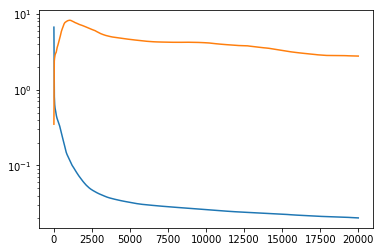

In [228]:
plt.plot(losses[0][:, 0])
plt.plot(priors[0][:, 0])
plt.yscale('log')

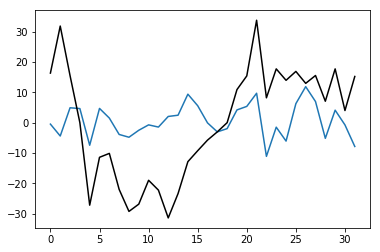

In [229]:
# plt.plot(xfinsspec[0].T)
plt.plot(xfinsspec[0].T.mean(axis=-1))
plt.plot(inits[0], 'k')
plt.show()

In [230]:
tf.reset_default_graph()
module = hub.Module(modname, trainable=False)

xx = tf.placeholder(tf.float32, shape=[None, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc], name='input')
rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']

sess = tf.Session()
sess.run(tf.global_variables_initializer())
reconfinsspec = sess.run(rate, feed_dict={xx:xfinsspec[0], yy:y})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


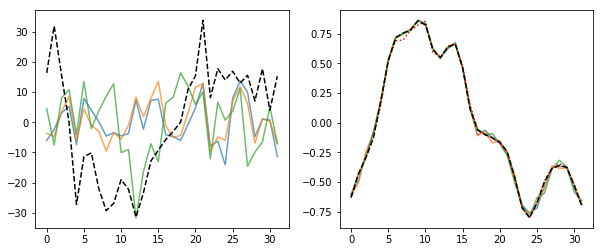

In [231]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

axis= ax[0]
for ii in (1, 5, 10):
    axis.plot(xfinsspec[0][ii], alpha=0.7)
axis.plot(inits[0], 'k--')

axis= ax[1]
for ii in (1, 5, 10):
    axis.plot(reconfinsspec[ii], alpha=0.7)
plt.plot(learn[0], 'r:')
plt.plot(fins[0]/fins.std(), 'k--')

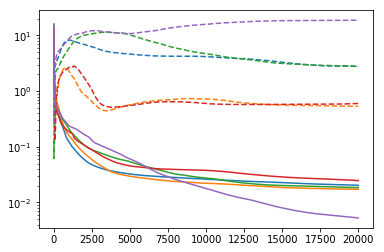

In [232]:
i = 0
# for ii in np.random.randint(0, 512, 5):
for ii in range(5):
    plt.plot(np.squeeze(np.array(losses[i])[:, ii]), 'C%d'%(ii%9))
    plt.plot(np.squeeze(np.array(priors[i])[:, ii]), 'C%d--'%(ii%9))
plt.yscale('log')
plt.show()


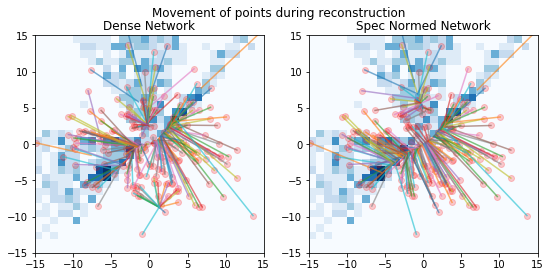

In [135]:
# With prior
fig, axar = plt.subplots(1, 2, figsize=(9, 4))

i=1
ii = 2*i
m = (sy == ii)
rrange = [[-15, 15],[-15, 15]]
bins = 30


ax = axar[0]
ax.hist2d(sx[:,0][m], sx[:,1][m],
                    bins=bins, range=rrange, normed=True, cmap='Blues') ;
ax.plot([xinit[i][:200,0],xfins[i][:200,0]], 
     [xinit[i][:200,1],xfins[i][:200,1]],alpha=0.6);

ax.scatter(xinit[i][:200,0], xinit[i][:200,1],alpha=0.2, color='r');
ax.set_title('Dense Network')

ax = axar[1]
ax.hist2d(sx[:,0][m], sx[:,1][m],
                    bins=bins, range=rrange, normed=True, cmap='Blues') ;
ax.plot([xinitspec[i][:200,0],xfinsspec[i][:200,0]], 
     [xinitspec[i][:200,1],xfinsspec[i][:200,1]],alpha=0.6);

ax.scatter(xinitspec[i][:200,0], xinitspec[i][:200,1],alpha=0.2, color='r');
ax.set_title('Spec Normed Network')
plt.suptitle('Movement of points during reconstruction')
plt.show()

# From samples generated by the learned networks

In [128]:
# tf.reset_default_graph()
# modname = './modules/specdensemodule/'
# xfinsspec = []
# losses = []
# xinitspec = []

# for i in range(6):
#     ii = 2*i
#     seed(100)
#     yy = ii* ones((512)).astype('float32')
#     xi = 5*randn(512,2)
#     xi = xi.astype('float32')
#     recons = dorecon(yy, xi, modname, useprior=True, niter=4000, lr=0.01)
#     xfin = np.squeeze(recons[0])
#     xfinsspec.append(xfin)
#     losses.append(np.squeeze(recons[1]))
#     priors.append(np.squeeze(recons[2]))
#     xinitspec.append(xi)

